# Breakpoint analysis (segmentation analysis)


Breakpoint analysis using segmentation aims to identify points in a dataset where the underlying trend or pattern changes significantly. It's particularly useful for time series data or data ordered along a single dimension.

**How it works:**

1.  **Segmentation:** The dataset is divided into segments. The goal is to find the optimal segmentation that minimizes the within-segment variability and maximizes the between-segment variability.
2.  **Cost Function:** A cost function is used to evaluate the quality of each segmentation. This function often measures the error or variance within each segment.
3.  **Optimization:** An optimization algorithm (e.g., dynamic programming, binary segmentation) is used to find the segmentation that minimizes the total cost. This involves exploring different segmentations and selecting the one with the lowest cost.
4.  **Breakpoint Identification:** The boundaries between the identified segments are considered breakpoints, indicating points of significant change.

**Key features:**

* **Identifying change points:** Reveals when significant shifts occur in data trends.
* **Flexibility:** Can be used with various cost functions and optimization algorithms.
* **Applications:** Useful in fields like finance, climate science, and signal processing.

**Example:**

Imagine a time series of temperature data. Segmentation might identify breakpoints where the temperature trend changes from a gradual increase to a more rapid increase, or where the data undergoes an offset due to the relocation of the weather station to a nearby location at a different altitude!




Let's make an artificial dataset of n=100 points to explain. In it we make two linear sloped data with some normally distributed noise added. That is, in each segment, we make a data set with 

$$ y_i = m x_i +c + \epsilon_i $$

To make life easier, we will also include the plot routine here :-)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_segmented_data(split_point, m1, c1, m2, c2, noise_std=1.0):
    """
    Generates two linear series with added noise, split at a given point.

    Args:
        split_point (int): The x-coordinate where the series are split.
        m1 (float): Slope of the first linear series.
        c1 (float): Intercept of the first linear series.
        m2 (float): Slope of the second linear series.
        c2 (float): Intercept of the second linear series.
        noise_std (float): Standard deviation of the added noise.

    Returns:
        tuple: A tuple containing x-coordinates, y-coordinates, and the two linear lines.
    """
    npts=100
    x = np.arange(npts)
    y = np.zeros(npts)
    
    # NOISE is normally distributed:
    eps = np.random.normal(0, noise_std, npts)

    y[:split_point] = m1 * x[:split_point] + c1 + eps[:split_point]
    y[split_point:] = m2 * x[split_point:] + c2 + eps[split_point:]

    line1 = m1 * x[:split_point] + c1
    line2 = m2 * x[split_point:] + c2

    return x, y, line1, line2


def plot_segmented_data(x, y, line1, line2, split_point):
    """
    Plots the segmented data and the linear lines.

    Args:
        x (numpy.ndarray): x-coordinates.
        y (numpy.ndarray): y-coordinates.
        line1 (numpy.ndarray): y-coordinates of the first linear line.
        line2 (numpy.ndarray): y-coordinates of the second linear line.
        split_point (int): The x-coordinate where the series are split.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(x, y, s=10, label="Data Points")
    ax.plot(x[:split_point], line1, color='red', label="True line 1")
    ax.plot(x[split_point:], line2, color='blue', label="True line 2")
    ax.axvline(x=split_point, color='gray', label="Split Point")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Segmented Linear Data with Noise")
    ax.legend()
    ax.grid(True)
    return fig, ax



Let's give it a try!

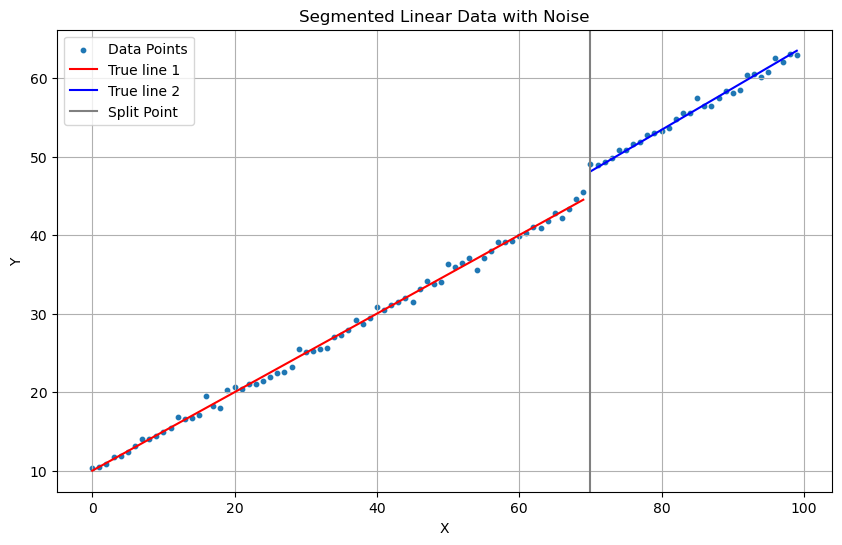

In [2]:

# Example usage:
split_point = 70
m1 = 0.5
c1 = 10
m2 = 0.53
c2 = 11
noise_std = 0.5

xpts, ypts, line1, line2 = generate_segmented_data(split_point, m1, c1, m2, c2, noise_std)
fig,ax=plot_segmented_data(xpts, ypts, line1, line2, split_point)


# Aside: Why are we doing this?



<details>
    <summary style="cursor: pointer;"><b>Why? (Click to expand)</b></summary>
    <div class="alert alert-block alert-info" style="margin-top: 10px;">
        <b>The Reason:</b> We could have downloaded a dataset of temperature or rainfall, written our breakpoint code and gone ahead. However, in science (and coding!) it is always a really good idea to test your theory against a use case where you <b>KNOW THE ANSWER!!!</b> This could be a simple boundary condition when solving equations, or in this case it is by inventing data where we know the answer.  This also allows you to play with the data, making variance larger or the slopes more similar in order to challenge the algorithm and see how it performs, or eventually fails!  Always do this for code you are developing whenever possible.
    </div>
</details>



# Segmentation Analysis

The idea is simple; one chooses an arbitrary point to split the time series, and two separate linear regression fits are made to the data prior to and after this point in time.  The mean square error is calculated between this fit and the original data, as a measure to how well this fit is; this is our "cost function" mentioned above.  By cycling through all possible breakpoints to identify the closest fit, we find the breakpoint.  Don't worry if you didn't understand this, we will go through it step by step.

To carry this out we will define some functions:

- **Split**: simply splits a timeseries at an arbitrary given time point and returns the two segments.

- **piecewise_polyfit**: fits the (linear) regression lines to the two portions (code can also perform higher order fits)

- **find_changepoint**: Cycles through the series using the above functions to split at each point and chooses the "best" one.

We start with the first two functions in this list...

In [3]:
from datetime import datetime, timedelta #

def split(x, n):
    # split a series at point n
    return x[:n], x[n:]

def piecewise_polyfit(x, y, n, order=1):
    
    y = np.ma.masked_array(y, np.isnan(y))

    # split x and y at point n 
    x1, x2 = split(x, n)
    y1, y2 = split(y, n)

    # fit nth order (default=1) fit to two parts
    p1 = np.ma.polyfit(x1, y1, order)
    p2 = np.ma.polyfit(x2, y2, order)

    # check for errors:
    if np.isnan(p1).any() or np.isnan(p2).any():
        raise ValueError('NaN for polyfit coeffs. Check data.')

    # make the series based on the two piecewise fits
    ypred1 = np.polyval(p1, x1)
    ypred2 = np.polyval(p2, x2)
    ypred = np.concatenate([ypred1, ypred2])

    # calculate the Mean Square error of the piecewise fit to the
    # original data, and return fit and RSS
    rss = np.sum((y - ypred)**2)
    return ypred, rss



let's try this first, fitting two lines to our data, let's pretend we "know" that the series break at x=40


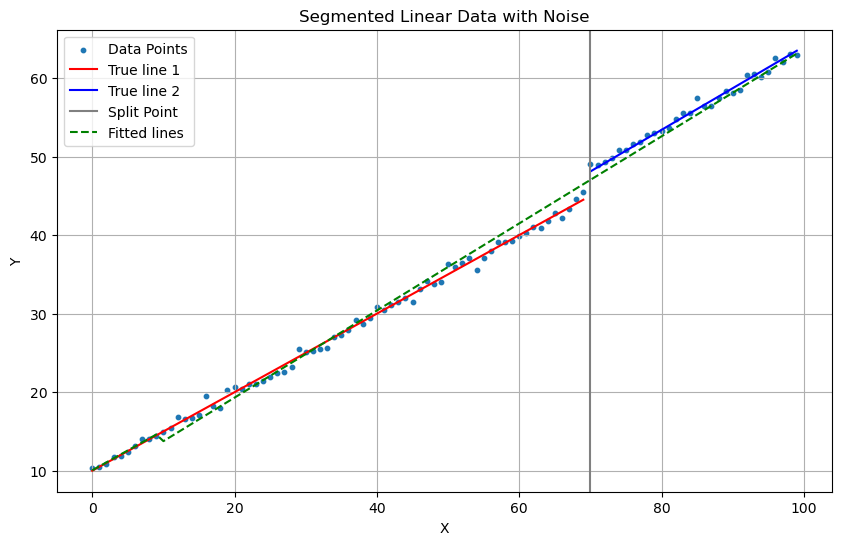

In [4]:
n=10
ypred,rss=piecewise_polyfit(xpts, ypts, n)
fig,ax=plot_segmented_data(xpts, ypts, line1, line2, split_point)

# now we add the fit lines
ax.plot(xpts,ypred,color='green', linestyle='--',label="Fitted lines")
ax.legend()

Ok, the fit was pretty good, but that is because we "knew" the answer!  Let's say we just took a guess at x=50 for the break, what do you think will happen? Edit $n$ and try! What happened to the error between the fit and the data, did it grow or reduce?


### let's all... minimize... 

Okay I think we got the concept, now all we need to do is cycle through the data point by point and try to find the break that minimizes the error!


In [5]:
from scipy import stats
def find_changepoint(x, y, order=1):
    rss = []
    buffer=20
    breaklist=list(range(buffer, len(x)- buffer))
    
    # swoop through the series, calculating RSS for each break point    
    # start can't be 2 for the covariance calculation, 
    # let's assume we need at least 10 datapoints anyway to get a reasonable fit
    for n in breaklist:
        _, rssval = piecewise_polyfit(x, y, n, order)
        rss.append(rssval)
    
    # x0 is the onset time from the minimum RSS
    n0 = np.nanargmin(rss)
    brk_point=breaklist[n0]

    x1, x2 = split(x, brk_point) #renamed breakpoint to split_point
    y1, y2 = split(y, brk_point) #renamed breakpoint to split_point
    p1_best = np.polyfit(x1, y1, order)
    p2_best = np.polyfit(x2, y2, order)

    print("split ",split_point)
    ypred, _ = piecewise_polyfit(x, y, brk_point, order) #renamed breakpoint to split_point

    return brk_point, ypred, rss



Let's try it out!


In [6]:
breakpt,ypred,rss = find_changepoint(xpts,ypts)

print ("break point is ",breakpt)

split  70
break point is  70


that's pretty close, let's take a look at the chosen fit.


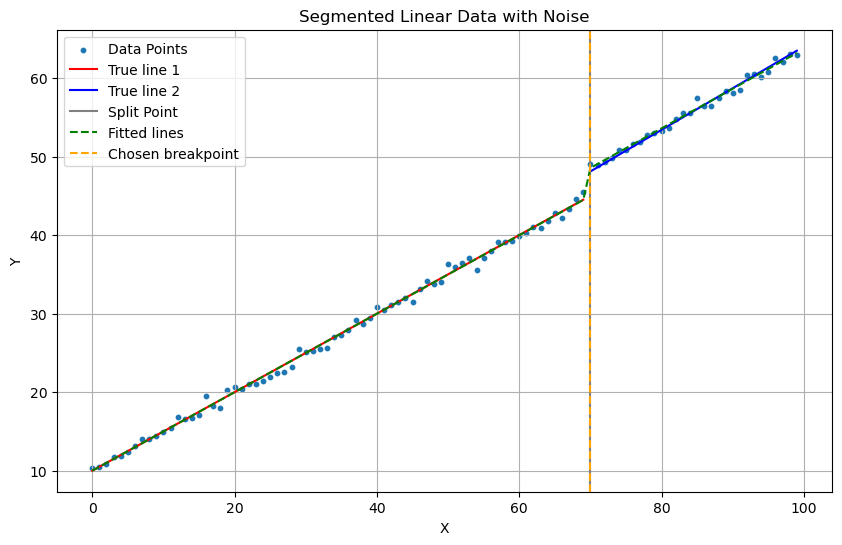

In [7]:
fig,ax=plot_segmented_data(xpts, ypts, line1, line2, split_point)

# now we add the fit lines
ax.plot(xpts,ypred,color='green', linestyle='--',label="Fitted lines")
ax.axvline(x=breakpt, color='orange', linestyle="--",label="Chosen breakpoint")
ax.legend()

## Davies' Test for Breakpoint Significance

The Davies' test is a statistical method used to assess the significance of a breakpoint identified through segmentation methods, particularly when using linear regression.

When performing segmented linear regression, we aim to find a breakpoint that best divides the data into two or more linear segments. However, simply finding a breakpoint that minimizes the residual sum of squares (RSS) doesn't guarantee its statistical significance. The Davies' test addresses this by providing a framework to determine if the observed breakpoint is likely due to chance or reflects a genuine change in the data's underlying relationship.

The standard hypothesis testing procedures are not readily applicable to breakpoint detection because:

* **Non-standard hypothesis:** The breakpoint is not pre-specified but rather determined by the data itself.
* **Multiple comparisons:** Searching through many potential breakpoints increases the risk of finding a "significant" breakpoint by chance (we'll come back to this point in the regression lesson next)
* **Non-standard distribution:** The distribution of the test statistic related to the breakpoint is often unknown or complex.

**Davies' Test**

The Davies' test tackles these issues by comparing the goodness of fit of a segmented regression model with that of a single linear regression model.

**Hypotheses:**

* **Null Hypothesis (H0):** There is no significant breakpoint in the data.
* **Alternative Hypothesis (H1):** There is a significant breakpoint in the data.

**Procedure:**

1.  **Fit a Single Linear Regression:**
Just as we did with the double segment  regression, we will fit a standard linear regression model to the entire dataset: $y = \beta_0 + \beta_1x + \epsilon$ using the same approach and calculate the residual sum of squares (RSS\_single).

2.  **Calculate the Test Statistic:**
We now need to calculate the test statistic, which Davies defines as the log ratio of the two fits: $t= n log(rss_{single} / rss_{piecewise})$ where $n$ is the number of datapoints. 

4.  **Calculate the degrees of freedome:**
We also have to calculate the degrees of freedom. Which, different to the regression test we will see next, is *not* related to $n$.  The number of data points (n) influence the power of the test (its ability to correctly reject the null hypothesis when it's actually false), but not the degrees of freedom. More data points generally lead to more precise parameter estimates and a higher likelihood of detecting a true effect. Degrees of freedom (df) relate to the number of parameters in the models being compared.  Its a tricky nuance because we will see that for correlation tests, the degrees of freedom *are* related to $n$

In the Davies test therefore the number of degrees of freedom is the extra number of parameters we need to fit for the segmentation breakpoint method. As we are using simple linear fits with two parameters (offset and slope), then simply:

$DF = 4 - 2 = 2$


5.  **Determine the P-Value:**

The Davies' test addresses the non-standard distribution of the test statistic by using simulations or asymptotic approximations to determine the p-value. for this assumption to be valid we need to be fitting to at least This p-value indicates the probability of observing the observed difference in RSS if there were no actual breakpoint.

7.  **Make a Decision:**
    * If the p-value is less than the significance level (e.g., 0.05 for a 95% confidence level), reject the null hypothesis and conclude that the breakpoint is statistically significant.
    * If the p-value is greater than the significance level, fail to reject the null hypothesis, suggesting that the breakpoint may be due to chance.



In [8]:
from scipy.stats import chi2  # Import chi2 from scipy.stats

def davies_test(x, y, breakpoint, order=1):
    """Implements a simplified Davies' test for breakpoint significance."""

    ypred_piecewise, rss_piecewise = piecewise_polyfit(x, y, breakpoint, order)

    p_single = np.polyfit(x, y, order)
    ypred_single = np.polyval(p_single, x)
    rss_single = np.sum((y - ypred_single)**2)

    n = len(x)
    k_single = order + 1  # Number of parameters in single regression
    k_piecewise = 2 * (order + 1)  # Number of parameters in piecewise regression

    # Calculate the test statistic (likelihood ratio test)
    if rss_piecewise == 0:
        return 1.0 # to avoid divide by zero errors.
    test_statistic = n * np.log(rss_single / rss_piecewise)

    # Calculate degrees of freedom
    df = k_piecewise - k_single

    # Calculate p-value using chi-squared distribution
    p_value = chi2.sf(test_statistic, df)

    return p_value



In [9]:
#breakpoint, rss_values = find_changepoint(xpts, ypts)

p_value = davies_test(xpts, ypts, breakpt)
print("Breakpoint:", breakpt)
print("P-value:", p_value)

if p_value < 0.05:
    print("Breakpoint is significant")
else:
    print("Breakpoint is not significant")

Breakpoint: 70
P-value: 3.687150663848927e-34
Breakpoint is significant


### Play and Discuss

Before we move on to a concrete application of the method, get into groups to play with the method. This example was easy, the break very clear, and the algorithm got it spot on. Now try out different values for the slopes and try to break the algorithm!!! For example, give both segments the same slope but different offsets (the kind of change that might happen if a weather station is moved for example).  What are the characteristics that challenge the algorithm ? Does the significance fail when you expect it to?

## **Monsoon Onset**

In this example we are going to use the onset index of [Walker and Bordoni (2016)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016GL071026), hereafter WB16.

Let's start by taking a look at the IMD onset monitoring from 2024.

<img src="https://mausam.imd.gov.in/ClimateInformation/imdweb/DAY_WEEK/onset_SW.gif" width=500 />

We notice that the monsoon progresses northwestward and thus the *local* onset of rains is latitude dependent.
Keeping this in mind, in this paper we will be attempting to derive a mean onset date for all-India. 

Let's start by looking at the mean precipitation for the box 10–30°N, 60–100°E, a large region that encompasses the Indian subcontinent and is frequently used domain for the South Asian summer Monsoon (SASM). We will simply use ERA5 here.  You will learn how to make this plot later...

<img src="images/ERA5_precip_2000.jpg" width="500" />

## **Discussion**

<div class="alert alert-block alert-info">
Break out into groups and quickly discuss these questions.

- Does the plot based on ERA5 resemble the paper plot using MERRA/GPCP?
- Look at the precipation graph, roughly at what day would you define the monsoon onset?
- What are the difficulties of using this field to define the onset?
- If you were to use a threshold rainfall event, how would you set it?
</div>

### The Walker-Bordoni onset index

The key concept of this paper is that rather than assessing the onset date for the monsoon based directly on the precipitation, it instead employed the large scale column water budget, which constrains net precipitation. This builds on Walker et al. 2015, who used a similar index for interannual variability.   

For a given region, we can write an equation for the rate of change of the total column water vapor $W$ (sometimes referred to as the "precipitable water", or referred to as TCWV in ECMWF grib table 128),  which is defined as $ W = \int ^0_{p_0} q_v \frac{dp}{g}$.  

The rate of change of $W$ is simply a sum of the atmospheric sources and sinks:

$$ \frac{\partial W}{\partial t} = MFC - P + E $$

where $P$ is precipitation, $E$ total surface evaporation, and $MFC$ is the moisture flux convergence, given by

$$ MFC = - \int^{p_s}_{0} \nabla . (u q_v) \frac{dp}{g} $$ 

where $u$ is the horizontal wind vector and $q_v$ is the specific humidity.

They show these terms in their Figure 1 for the year 2000, (panel a) for the region 10–30°N, 60–100°E, a large region that encompasses the Indian subcontinent and is frequently used domain for the South Asian summer Monsoon (SASM). Remember, each of these terms is calculated as an *area average*.  SB16 use MERRA reanalysis combined with GPCP for precipitation. 

Ignore the red line for now - we will explain what this is later on...


<img src="../images/SB16_fig1.jpg" width="500" height="300" />




## Discussion 
<div class="alert alert-block alert-info">
What are the key features of the precipitation, evaporation and storage?
</div>

- **Precipitation**:  The field is quite noisy in time, and starts to increase around day 150. 

- **Evaporation**: This exceeds the precipitation at the start of the year, when precipitation is essentially zero.  It increases in the rainy season as the soil moisture increases but the seasonal variation is much less than that of the precipitation. Note that we do not expect P~E over land averaged over time, why not?

- **Storage**: The $\frac{\partial W}{\partial t}$ storage term oscillates around zero; storage is not that important it seems! (This is not always so true for other monsoon systems).  Thus the divergence of water over the region is approximately in balance with $P-E$. In fact, as pointed out by WB16: *"With negligible storage $\frac{\partial W}{\partial t}$, the dominant balance in the SASM region is between MFC and net precipitation (P-E). Thus, positive (negative) values of MFC correspond to positive (negative) net precipitation."*

We will now examine these timeseries, trying to recreate this plot using ERA5 reanalysis data. 

If you are not familiar with netcdf file formats or the command line tool cdo ([climate data operators](https://code.mpimet.mpg.de/projects/cdo)) we suggest you follow the video series of [ClimateUnboxed](https://www.youtube.com/@climateunboxed).  The following box would allow you to download the data to your laptop and calculate the box averages.

On the Copernicus Climate Data store for ERA5, these are the names of the variables:


| eqn               | long name                                     |  ECMWF name |
|-------------------|-----------------------------------------------|-------------|
| $P$               | total_precipitation                           |  tp         |
| $E$               | evaporation                                   |  e          |
| $\frac{\partial W}{\partial t}$ | vertical_integeration_of_moisture_divergence | VIMD  |



VIMD is available from the reanalysis, but is usually not saved as a forecast product. We will return to this in the exercises. 

But before we start let's just import a few packages we will be needing and show you how to install others if any of them are missing in the box below



In [10]:
import numpy as np 
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import matplotlib.ticker as ticker

In [11]:
region="india" # india, nam...  

In [12]:
#
# you ONLY need these packages if you want to download the data yourself... 
# Uncomment these lines if so 
#
### pip install matplotlib
### import cdsapi
### from cdo import Cdo


<div class="alert alert-block alert-warning">
<b>WARNING</b> As the CDS is extremely slow at the moment, we prepared the timeseries data which can directly download using wget, or simply access directory online from the python netCDF4 utility, which is how this notebook operates
</div>
 
If you want to use the retrieve script later on, so you can change your data, you can watch the video tutorials on "ClimateUnboxed" and [see the instructions here](https://cds.climate.copernicus.eu/how-to-api) 

In this case set get_cds to True!


In [13]:
get_cds=False # we will use the pre-prepared datasets

In [14]:
#
# This shows you how to get the data yourself if you want to have the files locally
#
get_cds=False 
if get_cds:
    locdir="./" # where you want to put the data

    # make incidence 
    client=cdsapi.Client()
    cdo=Cdo()
    
    # dataset we are using:
    dataset = "derived-era5-single-levels-daily-statistics"
    
    for year in range(1961,1971):
        for var in [
            "total_precipitation",
            "evaporation",
            "vertical_integral_of_divergence_of_moisture_flux"
        ]:
            
            request = {
        "product_type": "reanalysis",
                "variable": var,
        "year": str(year),  # recall that the year needs to be a string!
        "month": [
            "01", "02", "03",
            "04", "05", "06",
            "07", "08", "09",
            "10", "11", "12"
        ],
        "day": [
            "01", "02", "03",
            "04", "05", "06",
            "07", "08", "09",
            "10", "11", "12",
            "13", "14", "15",
            "16", "17", "18",
            "19", "20", "21",
            "22", "23", "24",
            "25", "26", "27",
            "28", "29", "30",
            "31"
        ],
        "daily_statistic": "daily_mean",
        "time_zone": "utc+00:00",
                "frequency": "1_hourly",
                "area": [60, -180, -40, 180]
    }
    
            ifile=locdir+"era5_daily_"+str(year)+"_"+var+".nc"
            ofile=locdir+"era5_ts_"+str(year)+"_"+var+".nc"
            client.retrieve(dataset, request).download(ifile)
            cdo.fldmean(input="-sellonlatbox,60,100,10,30 "+ifile,output=ofile)

**alternative shortcut - prepared online data**

as the CDS has issues at the moment rendering it very slow, here we have prepared the files offline.

You can open [this URL](http://clima-dods.ictp.it/Users/tompkins/monsoons/data/) in a browser to see the file list. 

*Note that evaporation has been multiplied by -1 so that all terms are **positive** (negative) for atmospheric **sinks** (sources).*

In [15]:
#
# Let's just plot the moisture flux convergence. 
# this is fudge for datafile naming convention (ugh)
#
def get_file(region,var,year):
    datadir="http://clima-dods.ictp.it/Users/tompkins/monsoons/data/"
    if region=="india":
        file=datadir+var+"_"+str(year)+"_asia_sn10_30_we60_100.nc"
    if region=="nam":
        file=datadir+"era5_p_e_vimd_"+str(year)+"_daysum_NAM.nc"
    if region=="cumnam":
        file=datadir+"era5_p_e_vimd_"+str(year)+"_daysum_NAM_timcumsum.nc"
    url = (file+'#mode=bytes')
    dset = Dataset(url)
    return(dset)


In [16]:
# move the getting of data here to speed things up, 
# otherwise need to read in everytime we plot. 
# lets read into a dictory or a list of numpy arrays
def get_data(dlist,var,fldname,sf=1,year=2000):
    #ds=get_file(var,year)
    region="india"
    ds=get_file(region,var,year)
    fld=np.squeeze(ds[fldname])*sf
    dlist.append({"var":var,"data":fld,"year":year})
    return dlist

In [17]:
fldnames=["tp","e","vimd"]
vars=["prec","evap","vimd"]
sf=[1,-1,1]
dlist=[]
year=2000


#
# Cycle through the fields and add each dataset as a dictionary to the list
# 
for ivar,var in enumerate(vars):
    dlist=get_data(dlist,vars[ivar],fldnames[ivar],sf=sf[ivar],year=year)

In [24]:
# make a simple line plot for the 3 styles
def plotyear(dlist):
    fig,ax = plt.subplots()

    # hard wired 
    lstyles=["dashed","solid","solid"]
    lwidths=[2,1,1]
    lcols=["grey","grey","black"]
    tick_spacing=20
    
    # fudge to correct labels to something nicer
    labels={"evap":"evaporation","prec":"precipitation","vimd":"MFC"}

    for ivar,var in enumerate(dlist):
        ax.plot(var["data"],
                linestyle=lstyles[ivar],
                linewidth=lwidths[ivar],
                color=lcols[ivar],label=labels[var["var"]])

    ax.set_xlabel("day of year")
    ax.set_ylabel("(mm/day)")
    ax.set_title("year "+str(var["year"]))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.xticks(rotation=-45)
    ax.xaxis.grid(linestyle="dotted") # vertical lines
    ax.legend()
    plt.savefig("precip.jpg",bbox_inches='tight',dpi=300)
    return(fig,ax)
    


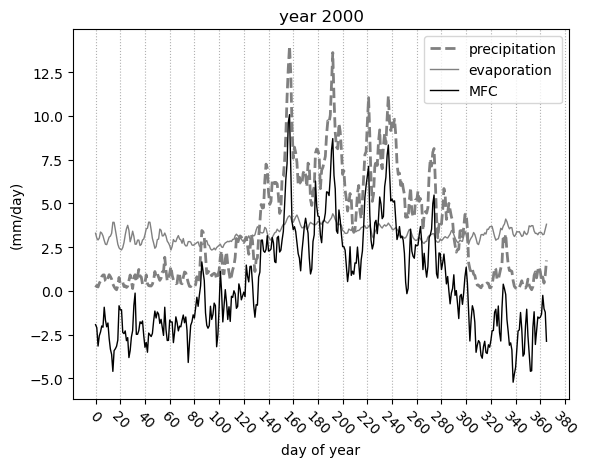

In [25]:

fig,ax=plotyear(dlist)


## **Discussion**

<div class="alert alert-block alert-info">

Break out into groups and quickly discuss these questions.

- Does the plot based on ERA5 resemble the paper plot using MERRA/GPCP?
- Can you think of any issues with using reanalysis for the budget calculations?
</div>


## **WB16 onset definition**

WB16 noted that the precipitation and divergence were quite noisy fields, making it difficult to use them to define a threshold for monsoon onset.  This is why often you will find onset definitions have a lot of "bolt-ons", that is, *"it needs to rain at least X much, for Y consecutive days and... and... "*

WB16 thus decided to use the **cumulative** water budget for the onset, which in fact is inspired by some onset definitions that are based on cumulative precipitation.  This is the origin of the **red line** in panel a above, which was labled CMFC, which in turn stood for *Cumulative Moisture Flux Convergence*.  Let's take a look at this.  The VIMD parameter is simply summed using the function 

**cdo timcumsum in.nc out.nc**

We've already calculated this for you, so let's just add it to the graph!







In [26]:
#first let's get the cmfc, only one field so we we extract 
# it from the list and only keep the data
#cmfc=get_data([],var="cum_vimd",fldname="vimd",year=year)[0]["data"]
cmfc=get_data([],var="cum_vimd",fldname="vimd",year=year)[0]["data"]

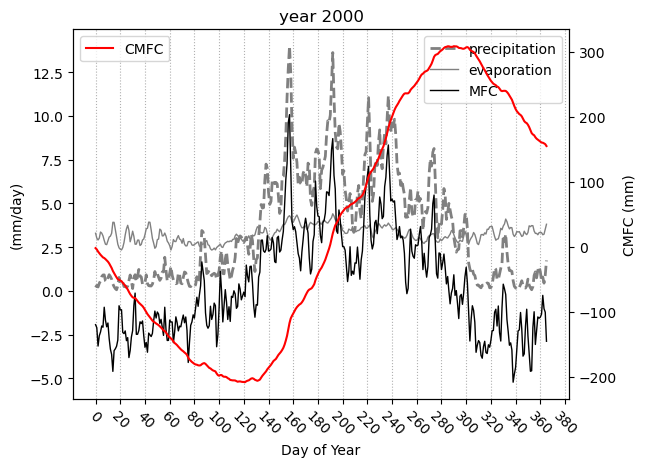

In [27]:

fig,ax=plotyear(dlist)

# add CMFC on rh y axis
ax2=ax.twinx()
ax2.plot(cmfc,label="CMFC",color="red")
ax.set_xlabel("Day of Year")
ax2.set_ylabel("CMFC (mm)")
ax2.legend()

plt.show()


## Discussion

<div class="alert alert-block alert-info">
- Can you think of a way to use the cumulative moisture divergence instead? How would this compare to your earlier estimate using the precipitation only?
</div>



WB16 suggested that the minimum of CMFC was a good metric of the monsoon onset; this is the point when the atmospheric moisture budget flips from net **export** to net **import** of water vapor in the broad monsoon region, again assuming negligible storage!

Now it remains to find a simple algorithm to identify the minimum in CMFC.
WB16 tackle this by using a method known as a [segmented regression](https://en.wikipedia.org/wiki/Segmented_regression) breakpoint analysis.  

Here we will show the method with an arbirtary split at day=140.

In [28]:
# first we define the number of time steps
ntim=len(cmfc)
# let's test an arbitrary break at day=140
pt=140 
x=list(range(ntim))
ypred,rssval = piecewise_polyfit(x,cmfc,pt)

fig,ax=plotyear(dlist)

# add CMFC on rh y axis
ax2=ax.twinx()
ax2.plot(cmfc,label="CMFC",color="red")
ax.set_xlabel("Day of Year")
ax2.set_ylabel("CMFC (mm)")
ax2.legend()

ax2.plot(ypred,color="green")

plt.show()


Okay... well this worked okay... ish, but...


## **Question**

<div class="alert alert-block alert-info">
What do you think causes the poor fit for the second segment and what would be a quick easy fix?
</div


The issue is that we are fitting just two linear segments, and after around day 250-300 when the monsoon is coming to an end, the CMFC slope becomes negative again and  the fit is thus quite poor (there are actually 3 segments in other words if we consider calendar years)...  We could try to do a 3-part fit, but an easier solution is to truncate the series at day 250 or so. 

In [31]:
cutoff=250
ypred_s,rssval = piecewise_polyfit(x[0:cutoff],cmfc[0:cutoff],pt)


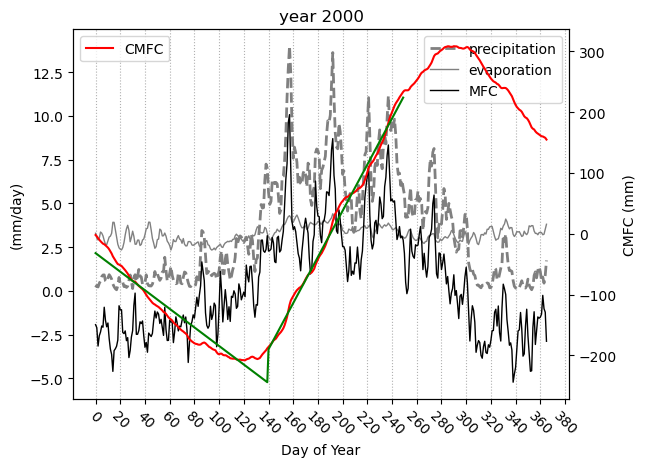

In [32]:
fig,ax=plotyear(dlist)

# add CMFC on rh y axis
ax2=ax.twinx()
ax2.plot(cmfc,label="CMFC",color="red")
ax.set_xlabel("Day of Year")
ax2.set_ylabel("CMFC (mm)")
ax2.legend()

ax2.plot(ypred_s,color="green")

plt.show()

Okay, that's much better now!  So now let's cycle over the series and minimize the RSS to find the breakpoint.  For that we define the third routine listed above.

In [34]:
day_onset,ypred_best,rss = find_changepoint(x[0:cutoff],cmfc[0:cutoff])

print (" The onset date is predicted to be at day ",day_onset)




split  70
 The onset date is predicted to be at day  125


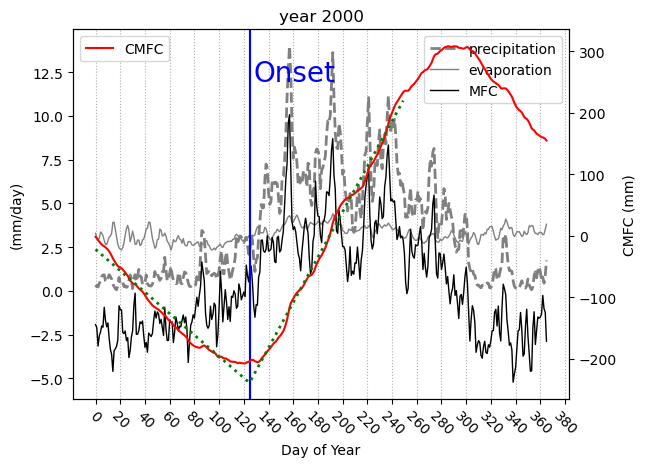

In [35]:
fig,ax=plotyear(dlist)


# add CMFC on rh y axis
ax2=ax.twinx()
ax2.plot(cmfc,label="CMFC",color="red")
ax.set_xlabel("Day of Year")
ax2.set_ylabel("CMFC (mm)")
ax2.legend()

ax2.plot(ypred_best,color="green",linestyle=":",linewidth=2)

# add vertical line at onset date
ax.axvline(day_onset,color="blue")
ax.axvline(day_onset,color="blue")
ax.text(x=day_onset+3,y=12,s="Onset",color="blue",size=20)

plt.show()

## Discussion

<div class="alert alert-block alert-info">

- Why is the piece-wise segmentation regression better (clue = more "robust") than simply finding the minimum of the CMFC?
- How does this breakpoint based onset compare to your initial estimate based on the precipitation timeseries? Is it earlier or later? Why do you think this is?

</div>

# **Exercises**

#### Basic:

1. The above exercise was conducted for the year 2000, which was the year used in fig 1 of WB16.  Repeat the above exercise for a few other years (include 2012 for example) so you get a feeling of the year to year variability in the time series.  Discuss within your groups, what are the robust features that stand out?  Are there any very abnormal years you can find?  Make a quick google search for exceptional years where the onset was particularly delayed or advanced, does this metric seem to agree?


#### Intermediate:

2. You have seen how to calculate the onset for a given year, now loop over all years on line and calculate the onset for each year. Make a timeseries plot to show the interannual variability in the onset dates.

3. Earlier you tried to estimate an onset date simply using a precipitation threshold.  Try to make a timeseries of onset dates using this threshold and see how it compares to the CMFC one.

4. Modify the code to detect the cessation dates. Is there a correlation between cessation anomaly and onset anomaly?

#### Advanced:

5. For many forecast systems, such as the operational forecasts on the CDS, the divergence is not calculated and stored.  In Fig 1 of WB16 we saw that $\frac{dW}{dt}$ is very limited.  You can calculate the storage term as a residual of $MFC$, $P$ and $E$.  Do this with the ERA data and convince yourself that the term is small. If you are convinced we can neglect it and assume no changes in atmospheric storage, then $MFC=P-E$.  Try out this approximation by recalculating the onset date using the approximation of the cumulative $P-E$. Make a scatter plot of  CMFC-based onset day and cumulative (P-E) onset day. What is the correlation?



### 4 Cessation Dates Clues

<summary>
    <details>
        <code>
cess_start=160  # why 160???
day_cess,ypred_best,rss,t_trend,p_trend,t_offset,p_offset=find_changepoint(x[cess_start:],cmfc[cess_start:])
day_cess+=cess_start
seas_len=day_cess-day_onset
        </code>
  </details>
</summary>



# **Potential Projects**

<div class="alert alert-block alert-info">

- Do you notice any trends in onset date? if you get the ERA5 retrievals working, try to go back to 1941 to the present

- If you have your favourite onset definition in a datafile somewhere, try to read it in and make a comparison. 

- seasonal forecast?  Take a look at the ECMWF Sys 5 forecasts, do they have any skill in predicting onset day?

- What about the CMIP6 ensemble, look at integrated P-E based onset and see if there are any trends that are clear by 2100?
</div>